In [1]:
%config IPCompleter.use_jedi = False

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import bz2
import matplotlib.pyplot as plt

In [3]:
with bz2.open('september_prepared.pkl.bz2', 'rb') as f:
    df = pickle.load(f)

- date - Date of shoping processing
- id_doc - Receipt ID
- id_card - Customer id
- id_order - If 0, than offline, otherwise online
- id_tov - PLU
- id_kontr - Distributor id
- quantity - Amount of bought items
- is_green - Discount
- sum - Sum of bought items

# Lets look at expensive receipts

In [84]:
tmp = df.groupby(by='id_doc_int', as_index=False).sum().sort_values(by='sum')
tmp

,id_doc_int,id_order,id_tov,id_kontr,quantity,sum,is_green,id_card_int
7095972,21554835,0,36247,-9999,1.000,0.00,0,318458
1190175,3614069,0,140549,78427,7.000,0.00,0,9101330
6317247,19187156,4666710,27126,-9999,1.000,0.00,0,307668
760844,2309968,0,647,-9999,1.000,0.00,0,1801342
6776349,20585534,0,647,-9999,1.000,0.00,0,18
...,...,...,...,...,...,...,...,...
5392918,16378256,313041300,876203,-145723,163.640,21358.98,0,87523300
3584565,10884556,469484022,1470370,-286455,171.061,21437.04,0,118651488
967281,2937461,1116371124,3619100,2477409,190.673,22825.48,0,335657658
1634577,4963467,286467818,1211673,743224,260.872,26956.31,0,27877570


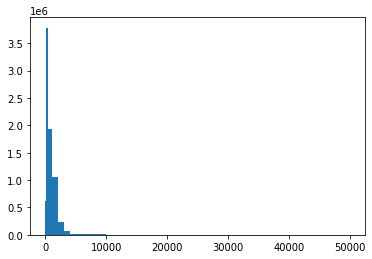

In [85]:
# Plot distribuition
figure = plt.figure()
_ = plt.hist(tmp['sum'].values, bins=[0,100,500,1000,2000,3000,4000,5000,10000,50000])

In [86]:
# Let's count mean, std and mean + 5*std
std, mean = tmp['sum'].values.std(), tmp['sum'].values.mean()
thresh = mean + std * 5
print(
    f'Mean: {mean}\n'
    f'Std: {std}\n'
    f'Mean + 5 sigma: {thresh}'
)

Mean: 627.4999515936923
Std: 675.3297112610709
Mean + 5 sigma: 4004.1485078990468


In [87]:
# 4k is ok, lets set ~10000
thresh = 10000

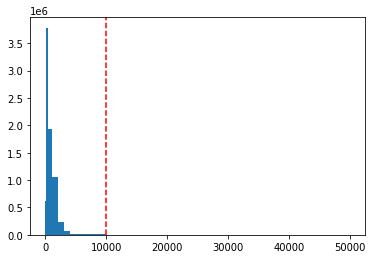

In [88]:
# Plot distribuition + theshold
figure = plt.figure()
_ = plt.hist(tmp['sum'].values, bins=[0,100,500,1000,2000,3000,4000,5000,10000,50000])
plt.axvline(thresh, ls='--', color='r')

In [89]:
#Let remember this customers as suspicious
susp_doc = tmp[tmp['sum']>thresh]['id_doc_int'].values
susp_receipt_customers = df[df['id_doc_int'].isin(susp_doc)]['id_card_int'].unique()

# Now lets look at customers themselves

In [9]:
tmp = df.groupby(by='id_card_int', as_index=False).sum().sort_values(by='sum')
tmp

,id_card_int,id_order,id_tov,id_kontr,quantity,sum,is_green,id_doc_int
1334505,1871302,0,21435,102,1.000,0.00,0,21829155
396386,527413,0,179951,86824,5.000,0.00,5,86521061
1316281,1843017,0,234032,113846,12.000,0.00,0,23359304
306743,405371,0,162821,75401,8.000,0.00,4,58061750
277094,365257,0,647,-9999,1.000,0.00,0,2932231
...,...,...,...,...,...,...,...,...
1054559,1447941,1846224652,11934022,4583099,767.353,98215.49,3,7513709846
1260542,1755035,19554147,279221,203854,51.000,116411.20,2,205354227
910003,1243870,0,14823178,9579794,1032.448,124131.91,5,7581114411
426570,568930,2234948749,17156402,8733962,1869.601,211154.31,8,5952086098


In [10]:
# Let's count mean, std and mean + 5*std
std, mean = tmp['sum'].values.std(), tmp['sum'].values.mean()
thresh = mean + std * 5
print(
    f'Mean: {mean}\n'
    f'Std: {std}\n'
    f'Mean + 5 sigma: {thresh}'
)

Mean: 3562.256118192547
Std: 16500.74977347565
Mean + 5 sigma: 86066.00498557079


In [11]:
#Let remember this customers as suspicious rich
susp_rich = tmp[tmp['sum']>thresh]['id_card_int'].values

# Lets explore if there are any inconsistancy in returns

In [12]:
# Check quantity less than 0
mask = (df['quantity']<0)
tmp = df[mask]
df[df['id_doc'].isin(tmp['id_doc'].values)].groupby('id_doc').agg({'sum' : ['sum', 'count']})

sum      
                                          sum count
id_doc                                             
0C31B577-6EEE-EA11-B444-005056A7539A    76.00     3
0F233BAE-71EE-EA11-B444-005056A7539A   511.76     7
0F874EE9-70EE-EA11-B444-005056A7539A  1137.93     8
16F60CE4-72EE-EA11-B444-005056A7539A   821.11     7
1CC214FB-70EE-EA11-B444-005056A7539A   448.00     4
2435A7A5-69EE-EA11-B444-005056A7539A   488.00     8
2565B1D7-70EE-EA11-B444-005056A7539A  1738.96    13
263901C1-75EE-EA11-B444-005056A7539A   700.00    12
2652B24D-6EEE-EA11-B444-005056A7539A   308.89     6
308D83A8-72EE-EA11-B444-005056A7539A   499.00     7
32BE14FB-70EE-EA11-B444-005056A7539A  1234.22    14
3720DAFC-6DEE-EA11-B444-005056A7539A   666.73    11
3848869D-75EE-EA11-B444-005056A7539A  2244.00    17
3AAF79A3-74EE-EA11-B444-005056A7539A   841.87     8
4453E687-69EE-EA11-B444-005056A7539A   531.67     7
49C21AF5-70EE-EA11-B444-005056A7539A  1644.27    15
4F2C3849-73EE-EA11-B444-005056A7539A   243.76     6
546133EE-6BEE-EA11-B444-005056A7539A   320.18     5
5ECEA601-70EE-EA11-B444-005056A7539A   793.00     7
662B4F74-76EE-EA11-B444-005056A7539A   309.00     4
6B5E05FB-6EEE-EA11-B444-005056A7539A   935.69     7
72D2D1DE-75EE-EA11-B444-005056A7539A   815.40    12
75C6368A-71EE-EA11-B444-005056A7539A  1021.00     9
79EAD54A-75EE-EA11-B444-005056A7539A   867.48     9
827B9591-75EE-EA11-B444-005056A7539A   417.26     4
85700678-70EE-EA11-B444-005056A7539A  1684.57    17
8B5F8150-76EE-EA11-B444-005056A7539A   774.30    11
8E4FC340-6AEE-EA11-B444-005056A7539A   600.00     6
8EAB9296-72EE-EA11-B444-005056A7539A   995.00     7
8ED5580D-72EE-EA11-B444-005056A7539A   354.39     7
95CFC996-73EE-EA11-B444-005056A7539A   178.20     4
980C5448-70EE-EA11-B444-005056A7539A   336.24     6
9816DAAF-76EE-EA11-B444-005056A7539A   281.00     5
9ABB512C-75EE-EA11-B444-005056A7539A   439.23     9
9D4128A9-73EE-EA11-B444-005056A7539A   728.00     8
A148C897-76EE-EA11-B444-005056A7539A   251.76     4
B338EDBE-6CEE-EA11-B444-005056A7539A   801.81     9
B47CB0BA-73EE-EA11-B444-005056A7539A  2701.98    23
B681FEE3-71EE-EA11-B444-005056A7539A    92.00     8
B887F69A-6CEE-EA11-B444-005056A7539A   326.00     5
CA3F2AC3-68EE-EA11-B444-005056A7539A   370.00     3
CD1BCB2C-77EE-EA11-B444-005056A7539A  1543.56    21
D124AF59-6DEE-EA11-B444-005056A7539A   694.00    12
D6ECFC00-6FEE-EA11-B444-005056A7539A    37.00     3
D9E8D54A-75EE-EA11-B444-005056A7539A  1610.68    18
DA7852A4-77EE-EA11-B444-005056A7539A   441.85     8
DAB53931-72EE-EA11-B444-005056A7539A  1761.07    18
E69CDDE4-73EE-EA11-B444-005056A7539A  1670.30    21
E6F17E03-78EE-EA11-B444-005056A7539A  1408.65    16
E9D1D1DE-75EE-EA11-B444-005056A7539A   483.00     5
EC3A01C1-75EE-EA11-B444-005056A7539A   882.90    10
ED63B1D7-70EE-EA11-B444-005056A7539A   641.98    11
F30A7366-71EE-EA11-B444-005056A7539A   176.00     3
F3379E71-6FEE-EA11-B444-005056A7539A   763.02     6
F6807973-75EE-EA11-B444-005056A7539A   253.00     5
F685F69A-6CEE-EA11-B444-005056A7539A   268.00     4
FA0646D2-72EE-EA11-B444-005056A7539A   178.42     3

In [19]:
# Returns distributions
tmp = df.groupby(by=['id_doc']).agg({
    'id_card_int': 'first',
    'sum': 'sum'
})
tmp = tmp[tmp['sum']==0].groupby('id_card_int').count().sort_values(by='sum')

In [25]:
tmp['sum'].mean()

1.6101694915254237

In [37]:
# Let's count mean, std and mean + 5*std
std, mean = tmp['sum'].std(), tmp['sum'].mean()
thresh = mean + std * 5
print(
    f'Mean: {mean}\n'
    f'Std: {std}\n'
    f'Mean + 5 sigma: {thresh}'
)

Mean: 1.6101694915254237
Std: 1.8721252528824244
Mean + 5 sigma: 10.970795755937546


In [38]:
susp_return = tmp[tmp['sum']>thresh].index.values

# Lets explore 0 quaninty (mb scales prankers)

### The ideas is that quantity can be near zero on self-checkout terminals, where goods sold by weight

In [45]:
df[df['quantity']==0].groupby('id_card_int').count().sort_values('id_doc_int')

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_doc_int
id_card_int,,,,,,,,,,
12751,1,1,1,1,1,1,1,1,1,1
804951,1,1,1,1,1,1,1,1,1,1
1858483,1,1,1,1,1,1,1,1,1,1
812051,1,1,1,1,1,1,1,1,1,1
894939,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
167734,2,2,2,2,2,2,2,2,2,2
840555,3,3,3,3,3,3,3,3,3,3
1731120,3,3,3,3,3,3,3,3,3,3


In [43]:
susp_quantity=[1766517]

In [56]:
# Now lets group all together

In [90]:
from collections import Counter

c = Counter()
c.update(susp_receipt_customers)
c.update(susp_rich)
c.update(susp_quantity)
c.update(susp_return)

In [91]:
for k, v in c.most_common():
    print(k) if v > 1 else 0

568930
935791
1755035


In [95]:
with open('outliers.txt', 'w') as f:
    for k, v in c.items():
        f.write(f'{k}\n')